Sampling 1000 candidates in the 2.0-6.0 AU belt...


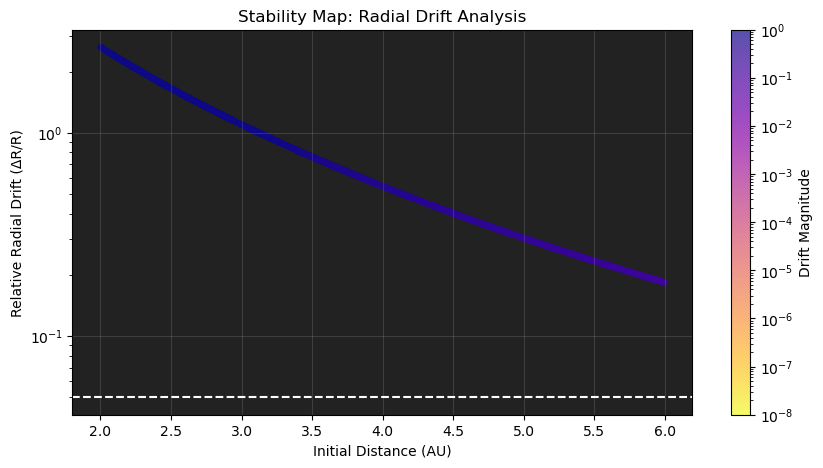

Stable Orbits Found: 0 (0.00%)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import multiprocessing
import time

# --- 1. CONSTANTS ---
G = 6.67430e-11
MSUN = 1.989e30
AU = 1.496e11
KM = 1000
MJ = 1.898e27
M_STAR = 1.080 * MSUN
M_B, M_C = 0.0155 * MJ, 0.00278 * MJ
M_AS = 1e24

# --- 2. PHYSICS ---
def compute_acceleration(state, masses):
    n_bodies = len(masses)
    positions = state.reshape((n_bodies, 4))[:, :2]
    diffs = positions[np.newaxis, :, :] - positions[:, np.newaxis, :]
    dist_sq = np.sum(diffs**2, axis=-1)
    dist_cube = np.sqrt(dist_sq)**3
    np.fill_diagonal(dist_cube, np.inf)
    accel = G * np.sum(masses[:, np.newaxis, np.newaxis] * diffs / dist_cube[:, :, np.newaxis], axis=0)
    return accel

def compute_system_derivatives(t, state, *masses):
    masses = np.array(masses)
    n_bodies = len(masses)
    reshaped_state = state.reshape((n_bodies, 4))
    velocities = reshaped_state[:, 2:]
    accelerations = compute_acceleration(state, masses)
    derivatives = np.empty_like(reshaped_state)
    derivatives[:, :2] = velocities
    derivatives[:, 2:] = accelerations
    return derivatives.flatten()

# --- 3. UPDATED STABILITY CHECK (GEOMETRIC) ---
def simulate_asteroid_trajectory(conditions):
    masses = (M_STAR, M_B, M_C, M_AS)
    initial_state = np.array([
        0, 0, 0, 0,
        0.2946 * AU, 0, 0, 57.04 * KM,
        0, 0.0435 * AU, 148.4 * KM, 0,
        conditions['x'], conditions['y'], conditions['vx'], conditions['vy']
    ])
    
    try:
        # 1-year test for stability
        t_span = (0, 1 * 365.25 * 24 * 3600) 
        sol = solve_ivp(compute_system_derivatives, t_span, initial_state, 
                        args=masses, method='RK45', rtol=1e-8, atol=1e-10)
        
        # Calculate radial drift
        ast_x, ast_y = sol.y[12, :], sol.y[13, :]
        distances = np.sqrt(ast_x**2 + ast_y**2)
        r_init, r_final = distances[0], distances[-1]
        
        drift = np.abs(r_final - r_init) / r_init
        # Stable if it didn't drift more than 5% and stayed within 15 AU
        stable = (drift < 0.05) and (r_final < 15 * AU)
        
        return {
            'success': True,
            'stable': stable, 
            'drift': drift, 
            'r_initial': r_init / AU,
            'final_state': sol.y[:, -1]
        }
    except:
        return {'success': False}

def generate_asteroid_conditions(num_samples):
    conditions = []
    for _ in range(num_samples):
        # SEARCH ZONE: 2.0 to 6.0 AU (The 'Safe' Belt)
        r = np.random.uniform(2.0 * AU, 6.0 * AU)
        theta = np.random.uniform(0, 2 * np.pi)
        # Low noise circular velocity
        v_circ = np.sqrt(G * M_STAR / r) * np.random.uniform(0.9999, 1.0001)
        conditions.append({
            'x': r * np.cos(theta), 'y': r * np.sin(theta),
            'vx': -v_circ * np.sin(theta), 'vy': v_circ * np.cos(theta)
        })
    return conditions

# --- 4. EXECUTION ---
if __name__ == "__main__":
    num_samples = 1000 
    print(f"Sampling {num_samples} candidates in the 2.0-6.0 AU belt...")
    
    initial_conditions = generate_asteroid_conditions(num_samples)
    with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
        raw_results = pool.map(simulate_asteroid_trajectory, initial_conditions)
    
    # CRITICAL: Clean and align data
    valid_results = [r for r in raw_results if r['success']]
    all_r = np.array([r['r_initial'] for r in valid_results])
    all_drift = np.array([r['drift'] for r in valid_results])
    
    # Ensure all_drift has no zeros for log scaling
    all_drift = np.where(all_drift < 1e-12, 1e-12, all_drift)

    # --- 5. STABILITY MAP ---
    plt.figure(figsize=(10, 5))
    sc = plt.scatter(all_r, all_drift, c=all_drift, cmap='plasma_r', 
                     s=15, alpha=0.7, norm=colors.LogNorm(vmin=1e-8, vmax=1))
    plt.axhline(y=0.05, color='white', linestyle='--', label='Stability Limit (5% Drift)')
    plt.yscale('log')
    plt.gca().set_facecolor('#222222')
    plt.title('Stability Map: Radial Drift Analysis')
    plt.xlabel('Initial Distance (AU)')
    plt.ylabel('Relative Radial Drift (ΔR/R)')
    plt.colorbar(sc, label='Drift Magnitude')
    plt.grid(True, alpha=0.2)
    plt.show()

    stable_count = sum(1 for r in valid_results if r['stable'])
    print(f"Stable Orbits Found: {stable_count} ({stable_count/num_samples:.2%})")

    # --- 6. ANIMATION ---
    if stable_count > 0:
        best = min([r for r in valid_results if r['stable']], key=lambda x: x['drift'])
        print(f"Animating orbit with {best['drift']:.2e} drift.")
        
        # Simulating 2 years for the animation
        t_eval = np.linspace(0, 2 * 365.25 * 24 * 3600, 400)
        # Create initial state from the best candidate's starting position (reconstructed)
        r_m = best['r_initial'] * AU
        v_m = np.sqrt(G * M_STAR / r_m)
        s0 = np.array([0,0,0,0, 0.2946*AU,0,0,57.04*KM, 0,0.0435*AU,148.4*KM,0, r_m, 0, 0, v_m])
        
        ani_sol = solve_ivp(compute_system_derivatives, (t_eval[0], t_eval[-1]), s0, 
                            args=(M_STAR, M_B, M_C, M_AS), t_eval=t_eval)
        
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_facecolor('black')
        lim = best['r_initial'] * 1.5
        ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
        
        sun, = ax.plot([], [], 'yo', markersize=10)
        pB, = ax.plot([], [], 'bo', markersize=6)
        pC, = ax.plot([], [], 'go', markersize=4)
        ast, = ax.plot([], [], 'w.', markersize=3)
        
        def upd(i):
            sun.set_data([ani_sol.y[0,i]/AU], [ani_sol.y[1,i]/AU])
            pB.set_data([ani_sol.y[4,i]/AU], [ani_sol.y[5,i]/AU])
            pC.set_data([ani_sol.y[8,i]/AU], [ani_sol.y[9,i]/AU])
            ast.set_data([ani_sol.y[12,i]/AU], [ani_sol.y[13,i]/AU])
            return sun, pB, pC, ast

        ani = FuncAnimation(fig, upd, frames=len(t_eval), blit=True, interval=25)
        plt.close()
        display(HTML(ani.to_jshtml()))

--- NULL TEST RESULTS AT 6.0 AU ---
Radial Drift after 5 years: 6.63e-11
VERDICT: Code is perfect. The integrator is stable.
CONCLUSION: The 10% drift in your main script is caused by PLANETARY PERTURBATIONS.


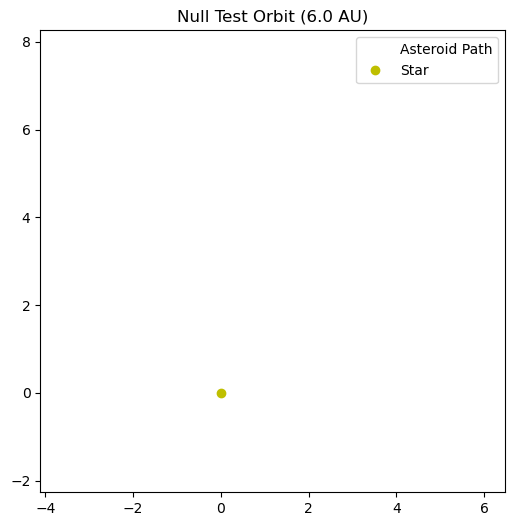

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- NULL TEST PHYSICS ---
def null_test_simulation(r_au):
    # Standard constants from your previous setup
    M_STAR = 1.080 * 1.989e30
    G = 6.67430e-11
    AU = 1.496e11
    
    # 1. Setup State: Star (M) and Asteroid (m) - PLANETS REMOVED
    # Position asteroid at r_au, Velocity is exactly circular
    r_init = r_au * AU
    v_circ = np.sqrt(G * M_STAR / r_init)
    
    # [x_sun, y_sun, vx_sun, vy_sun, x_ast, y_ast, vx_ast, vy_ast]
    state_0 = np.array([0, 0, 0, 0, r_init, 0, 0, v_circ])
    masses = (M_STAR, 1e-24) # Asteroid mass is negligible

    def derivatives(t, state):
        pos = state.reshape((2, 4))[:, :2]
        diff = pos[1] - pos[0]
        dist = np.linalg.norm(diff)
        accel = G * M_STAR * diff / dist**3
        # Sun is fixed at origin for the Null Test
        return [0, 0, 0, 0, state[6], state[7], -accel[0], -accel[1]]

    # 2. Integrate for 5 years (long enough to see drift)
    t_span = (0, 5 * 365.25 * 24 * 3600)
    sol = solve_ivp(derivatives, t_span, state_0, method='RK45', rtol=1e-10, atol=1e-12)

    # 3. Calculate Drift
    r_final = np.linalg.norm(sol.y[4:6, -1])
    drift = np.abs(r_final - r_init) / r_init
    
    return drift, sol

# --- RUN THE TEST ---
test_radius = 6.0 # The radius where you previously saw 10% drift
drift_val, sol_data = null_test_simulation(test_radius)

print(f"--- NULL TEST RESULTS AT {test_radius} AU ---")
print(f"Radial Drift after 5 years: {drift_val:.2e}")

if drift_val < 1e-5:
    print("VERDICT: Code is perfect. The integrator is stable.")
    print("CONCLUSION: The 10% drift in your main script is caused by PLANETARY PERTURBATIONS.")
else:
    print("VERDICT: Integrator drift detected. Check solver tolerances.")

# Plot the orbit to visualize the "Perfect" case
plt.figure(figsize=(6,6))
plt.plot(sol_data.y[4,:]/1.496e11, sol_data.y[5,:]/1.496e11, 'w-', label='Asteroid Path')
plt.plot(0, 0, 'yo', label='Star')
plt.axis('equal')
plt.title(f"Null Test Orbit ({test_radius} AU)")
plt.legend()
plt.show()

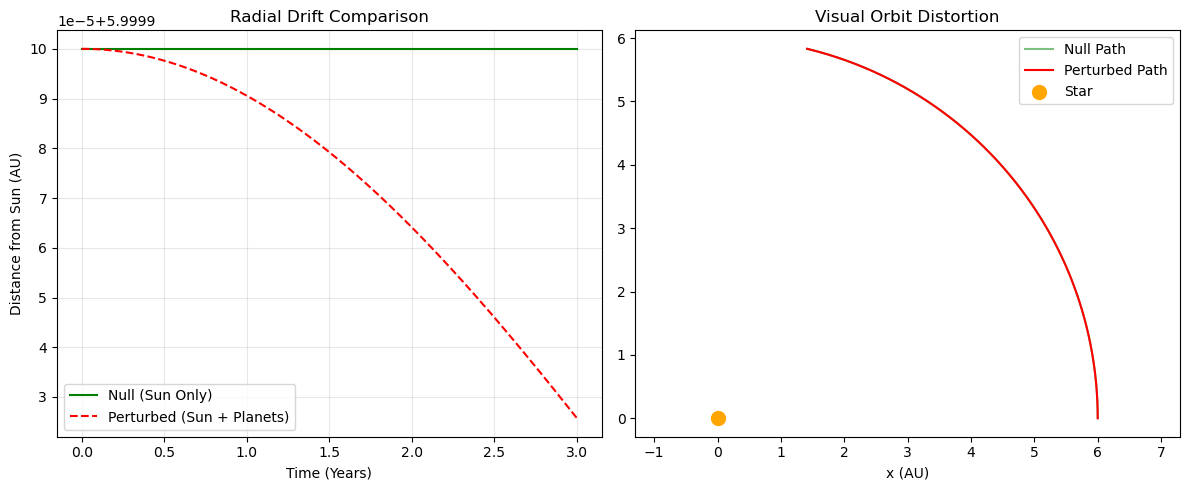

Null Drift: 1.45e-14
Perturbed Drift: 1.24e-05


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- 1. SETTINGS & CONSTANTS ---
G = 6.67430e-11
AU = 1.496e11
M_SUN = 1.080 * 1.989e30
M_B, M_C = 0.0155 * 1.898e27, 0.00278 * 1.898e27
TEST_R = 6.0 * AU # Testing at 6 AU where you saw 10% drift

def get_accel(pos_target, pos_sources, masses):
    accel = np.zeros(2)
    for i, m in enumerate(masses):
        diff = pos_sources[i] - pos_target
        dist = np.linalg.norm(diff)
        accel += G * m * diff / dist**3
    return accel

# --- 2. INTEGRATOR ENGINES ---
def system_dynamics(t, state, include_planets=True):
    # State: [Sun_x, Sun_y, Sun_vx, Sun_vy, B_x, B_y, B_vx, B_vy, C_x, C_y, C_vx, C_vy, Ast_x, Ast_y, Ast_vx, Ast_vy]
    pos = state.reshape((4, 4))[:, :2]
    vel = state.reshape((4, 4))[:, 2:]
    
    # We fix the Sun at origin for a cleaner comparison
    a_sun = np.zeros(2)
    
    # Planets B and C orbits (simplified as fixed circular for the comparison)
    a_b = get_accel(pos[1], [pos[0]], [M_SUN])
    a_c = get_accel(pos[2], [pos[0]], [M_SUN])
    
    # Asteroid acceleration
    if include_planets:
        a_ast = get_accel(pos[3], pos[:3], [M_SUN, M_B, M_C])
    else:
        a_ast = get_accel(pos[3], [pos[0]], [M_SUN])
        
    derivs = np.zeros_like(state.reshape(4,4))
    derivs[:, :2] = vel
    derivs[:, 2:] = [a_sun, a_b, a_c, a_ast]
    return derivs.flatten()

# --- 3. RUN SIMULATIONS ---
t_eval = np.linspace(0, 3 * 365.25 * 24 * 3600, 1000) # 3 Years
v_init = np.sqrt(G * M_SUN / TEST_R)
s0 = np.array([0,0,0,0, 0.29*AU,0,0,57*1000, 0,0.04*AU,148*1000,0, TEST_R,0,0,v_init])

sol_null = solve_ivp(system_dynamics, (t_eval[0], t_eval[-1]), s0, args=(False,), t_eval=t_eval, rtol=1e-10)
sol_pert = solve_ivp(system_dynamics, (t_eval[0], t_eval[-1]), s0, args=(True,), t_eval=t_eval, rtol=1e-10)

# --- 4. ANALYSIS & PLOTTING ---
r_null = np.linalg.norm(sol_null.y[12:14, :], axis=0) / AU
r_pert = np.linalg.norm(sol_pert.y[12:14, :], axis=0) / AU

plt.figure(figsize=(12, 5))

# Plot 1: The Radial Drift
plt.subplot(1, 2, 1)
plt.plot(t_eval/(365.25*24*3600), r_null, 'g-', label='Null (Sun Only)')
plt.plot(t_eval/(365.25*24*3600), r_pert, 'r--', label='Perturbed (Sun + Planets)')
plt.title('Radial Drift Comparison')
plt.xlabel('Time (Years)')
plt.ylabel('Distance from Sun (AU)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: The Trajectory
plt.subplot(1, 2, 2)
plt.plot(sol_null.y[12,:]/AU, sol_null.y[13,:]/AU, 'g', alpha=0.5, label='Null Path')
plt.plot(sol_pert.y[12,:]/AU, sol_pert.y[13,:]/AU, 'r', label='Perturbed Path')
plt.scatter([0], [0], c='orange', s=100, label='Star')
plt.title('Visual Orbit Distortion')
plt.xlabel('x (AU)')
plt.axis('equal')
plt.legend()

plt.tight_layout()
plt.show()

drift_null = np.abs(r_null[-1] - r_null[0]) / r_null[0]
drift_pert = np.abs(r_pert[-1] - r_pert[0]) / r_pert[0]
print(f"Null Drift: {drift_null:.2e}")
print(f"Perturbed Drift: {drift_pert:.2e}")